Created by Daniel Silalahi (Student Number:21073058)

Download the Data


In [ ]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!pip install unicode


import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

In [ ]:
#Make a ./data/project directory
!mkdir data
!mkdir data/project

Insert and process link to data


In [ ]:
!curl 'filename' -o data/project/'filename'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: filename


Install tweepy


In [ ]:
!pip install tweepy

Twitter Data


In [ ]:
import tweepy
import pandas as pd

consumer_key = "g1HqYDd0uqJrhefHhpkDRxbUb"
consumer_secret = "KbhPjZiLmjFySqWh6WNw5FGFgLJR2NiMhcOVZemfyZXXECqJkj"
access_key = "1128328751157133313-dtgTxSnjRaYTYywqoJtm4I8taUjyhs"
access_secret = "ZuOnAivKugIvQs4HKm82qSpBhzAOKVKdJjq8NirZ43RLA"

# Twitter authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

# Creating an API object
api = tweepy.API(auth)

# create a query for tweets, but exclude retweets and replies
tweets = tweepy.Cursor(api.search,
                       q="roevwade exclude:replies exclude:retweets",
                       tweet_mode='extended').items()

list = []
for tweet in tweets:
    text = tweet._json["full_text"]

    refined_tweet = {'text' : text,
                    'date' : tweet.created_at}

    list.append(refined_tweet)

df = pd.DataFrame(list)
print(df.head())


AttributeError: 'API' object has no attribute 'search'

Clean text (remove emojis or ani non ASCII characters) and remove date, as it is only a short time period (1 week)

In [ ]:
import re

# Create a new dataframe text column
df_cleaned = pd.DataFrame(columns=['Text'])

# Clean up values of df['text'] and insert into df_cleaned['Text']
#https://stackoverflow.com/questions/36340627/remove-non-ascii-characters-from-pandas-column
df_cleaned['Text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')

# Lowercase all text to make analysis easier
df_cleaned['Text'] = df_cleaned['Text'].str.lower()


# clean other parts of text, such as mentions, hashtags, links, etc
# https://docs.python.org/3/library/re.html
# https://medium.com/@oscar.sefa/twitter-sentiment-analysis-using-python-for-beginners-1ee1bc15dc86
def cleanTweets(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text) #removes @mentions
    text = re.sub('#','',text) #removes hashtag symbol
    text = re.sub('https?:\/\/\S+', '', text)  #Removes links
    text = re.sub('\n',' ',text) # Removes any blank lines of space within tweets,
    return text                  # makes one big paragraph instead of multiple smaller ones


df_cleaned['Text'] = df_cleaned['Text'].apply(cleanTweets) #apply cleanTweet function to the tweet
print('Original Data')
print(df.head())
print('\nCleaned Data')
print(df_cleaned.head())

Original Data
                                                text                date
0  Watching the New Amsterdam episode on RoeVWade... 2023-01-03 18:39:20
1  Check out our episode on #RoeVWade &amp; #Chap... 2023-01-03 18:32:45
2  🚨 The same legal arguments used to overturn #R... 2023-01-03 17:45:09
3  (OPINION/@tweetmattingly) Churches were always... 2023-01-03 17:29:30
4  States enacted 50 #abortion restrictions in 20... 2023-01-03 16:38:57

Cleaned Data
                                                Text
0  watching new amsterdam episode feeling physica...
1  check episode roevwade chappelle tomorrow spec...
2  legal arguments used overturn roevwade also th...
3  (opinion/) churches always active abortion deb...
4  states enacted 50 abortion restrictions 2022, ...


Create a list that contains full sentences of abortion in tweet


In [ ]:
#https://docs.python.org/3/library/collections.html
from collections import Counter

# Find most common words
word_count = Counter(" ".join(df_cleaned["Text"]).split()).most_common(20)

# Create a dataframe with most common words
frequent_words = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])

print(frequent_words)

                    Word  Frequency
0               roevwade        189
1               abortion         58
2                  court         18
3                 scotus         18
4                  women         18
5                    new         17
6                  right         17
7                    roe         17
8                   year         17
9                  trump         15
10                 state         14
11                health         14
12               supreme         12
13          supremecourt         12
14                racism         12
15                 legal         11
16              overturn         11
17              decision         11
18        abortionrights         11
19  abortionishealthcare         11


Creating a bar chart displaying most common words

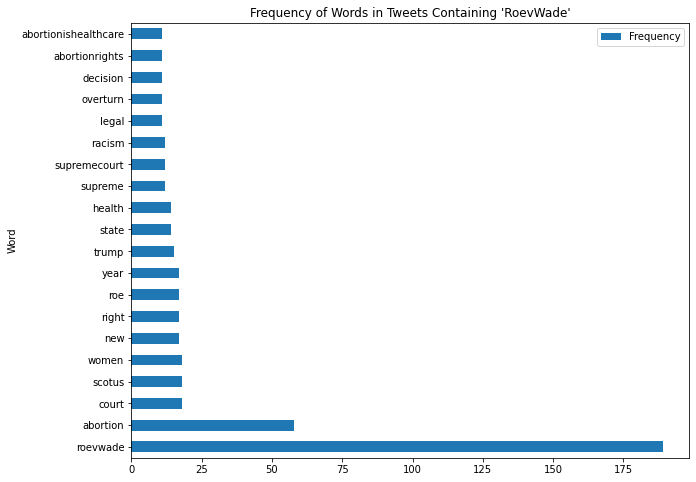

In [ ]:
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
import matplotlib.pyplot as plot

frequent_words.plot.barh(x="Word", y="Frequency", title="Frequency of Words in Tweets Containing 'RoevWade'");

plot.show(block=True)

Sentiment Analysis

Sentiment analysis is the computational study of people's opinions, sentiments, emotions, appraisals, and attitudes towards entities such as products, services, organizations, individuals, issues, events, topics, and their attributes. Let's study the sentiment of the tweets in this dataset.

spacytextblob performs sentiment analysis using the TextBlob library. Adding spacytextblob to a spaCy nlp pipeline creates a new extension attribute for the Doc.

In [ ]:
#Create a new dataframe for sentiment analysis column
df_sentimentAnalysis = pd.DataFrame(columns=['Text'])
df_sentimentAnalysis['Text'] = df['text']

df_sentimentAnalysis['Text'] = df_sentimentAnalysis['Text'].str.encode('ascii', 'ignore').str.decode('ascii')
df_sentimentAnalysis['Text'] = df_sentimentAnalysis['Text'].apply(cleanTweets)

df_sentimentAnalysis['Polarity'] = df_sentimentAnalysis['Text'].apply(lambda x: nlp(x)._.blob.polarity)
df_sentimentAnalysis['Subjectivity'] = df_sentimentAnalysis['Text'].apply(lambda x: nlp(x)._.blob.subjectivity)

# Function to return positive, neutral, negative according to the polarity
def analysis(score):
  if score>0:
        return 'Positive'
  elif score ==0:
        return 'Neutral'
  else:
        return 'Negative'

#apply function to the 'Polarity' column and store values in a new column named 'Analysis'
df_sentimentAnalysis['Analysis'] = df_sentimentAnalysis['Polarity'].apply(analysis)

# create a new df for subjectivity >= 0.5
df_subjective = df_sentimentAnalysis[df_sentimentAnalysis['Subjectivity'] >= 0.5]

print('Sentiment Analysis')
print(df_sentimentAnalysis.head())
print('\nSentiment Analysis for Subjectivity>=0.5')
print(df_subjective.head())

NameError: ignored

Create a pie chart of Polarity

Positive    109
Neutral      81
Negative     35
Name: Analysis, dtype: int64


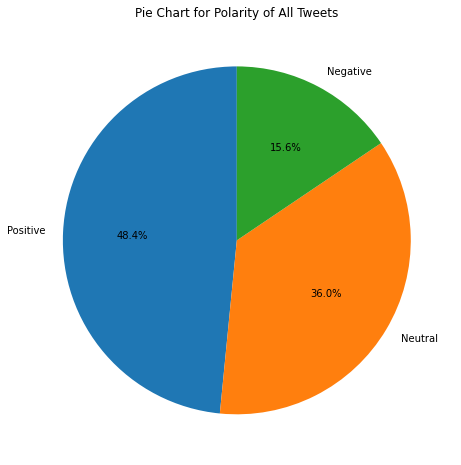

Positive    59
Negative    20
Neutral      1
Name: Analysis, dtype: int64


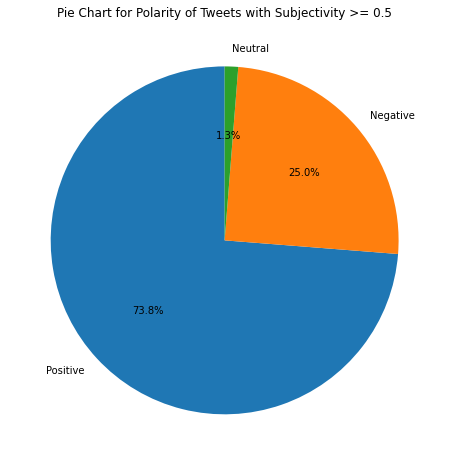

In [ ]:
#https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html


# Pie chart for analysis:
pie_chart_values = df_sentimentAnalysis['Analysis'].value_counts()
print(pie_chart_values)
pie_chart_values.plot(kind = 'pie', label='', autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Polarity of All Tweets')
plt.show()

# create a pie chart for analysis but only for subjectivity >= 0.5
pie_chart_values = df_subjective['Analysis'].value_counts()
print(pie_chart_values)
pie_chart_values.plot(kind = 'pie', label='', autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Polarity of Tweets with Subjectivity >= 0.5')
plt.show()


Creating a Scatterplot of Polarity and Subjectivity

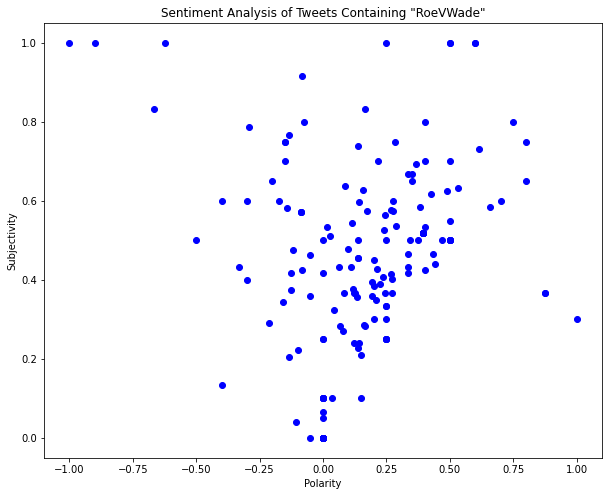

In [ ]:
#create a loop that repeats for amount of rows the df_sentimentAnalysis has
for row in range(df_sentimentAnalysis.shape[0]):
    plt.scatter(df_sentimentAnalysis['Polarity'][row], df_sentimentAnalysis['Subjectivity'][row], color='blue')
plt.title('Sentiment Analysis of Tweets Containing "RoeVWade"')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

To get a sense of what the nlp model defines as high or low polarity, we will print the 5 tweets of lowest polarity and 5 tweets with highest polarity

In [ ]:
# get the 5 lowest polarity values
lowest5 = df_subjective.nsmallest(5, 'Polarity')

# get the 5 highest polarity values
highest5 = df_subjective.nlargest(5, 'Polarity')

# print the text of 5 rows of lowest polarity
count = 1
print('Lowest Polarity:')
for text in lowest5['Text']:
    print(count, ': ', text)
    count += 1

# print the text of 5 rows of highest polarity
count = 1
print('\nHighest Polarity:')
for text in highest5['Text']:
    print(count, ': ', text)
    count += 1

Lowest Polarity:
1 :  Outrageous RoeVWade 
2 :  Progressives in 2016, "We won't be voting for the DemocraticNominee and dont care if DonaldTrump becomes President"  Progressives today, "We are "Outraged" that the SupremeCourt that was appointed by FormerPresidentTrump voted to overturn RoeVWade"   Which is it??? 
3 :  MuskRat  TwitterGate Education   FauciFiles  GinniThomas   january6thinsurrection  pfizerdocuments RoeVWade  FamilyAffair  EducationForAll racism  Health Idiotic decadence NewYear 
4 :  I know where Ill be! RoeVWade 
5 :  RoeVWade SCOTUS AbortionIsMurder were the talk of the month &amp; in fact still is, but was merely a BLIP on the June, 2022 GodSmacks WIR Blog pages:  

Highest Polarity:
1 :  Great thread trump RoeVWade 
2 :  You know the best thing about being pro-choice? It literally gives you the opportunity to mind your own damn business.  RoeVWade ProChoice herbodyherchoice
3 :  It's NationalCandyCaneDay and if you love democracy just as much as a delicious ros it'